# Implementação do Laboratório 01

Equipe: 01

Alunos:
- Francisco Pereira da Silva Filho (122110393)
- Hebert Laurentino dos Santos (122110606)
- Pedro Henrique Lima Simões (122110198)
- Samuel Lucas Vieira Matos (122110085)

## Implementação Manual do Algoritmo CRC

In [13]:
# Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
def xor_bits(a, b):
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado


# Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

# Args:
#     dados_bits: A string binária representando o polinômio da mensagem, M(x).
#     gerador_bits: A string binária representando o polinômio gerador, G(x).
    
# Returns:
#     A string binária de r bits representando o CRC.
def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    # Grau do gerador
    r = len(gerador_bits) - 1

    # 2. T(x) = M(x) * 2^r
    mensagem_aumentada = list(dados_bits + '0' * r)

    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            inicio = i
            fim = i + r + 1

            janela_atual = "".join(mensagem_aumentada[inicio : fim])
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    resto = "".join(mensagem_aumentada[-r:])
    return resto

### Comparando resultados

Para os dados:

```
dados_teste = "1101011111"  # M(x)
gerador_teste = "10011"     # G(x)
```

O Resultado esperado é:
```
Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado: 0010
```

In [14]:
dados_teste = "1101011111"  # M(x)
gerador_teste = "10011"     # G(x)
crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

print(f"Dados M(x): {dados_teste}")
print(f"Gerador G(x): {gerador_teste}")
print(f"CRC Calculado: {crc_calculado}")

Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado: 0010


___

## Análise Comparativa de Desempenho entre Manual e Biblioteca CRC

### Preparando o ambiente

1. Instalando CRC.

In [15]:
pip install crc

Note: you may need to restart the kernel to use updated packages.


### Gerando mensagens e comparando resultados

In [16]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16

calculator_lib = Calculator(Crc16.MODBUS)

# Tamanhos de mensagem para teste (em bytes)
tamanhos_bytes = [1500, 3000, 6000, 16000]

resultados = []

for tamanho in tamanhos_bytes:
    print(f"Analisando para mensagem de {tamanho} bytes...")
    # Gera uma mensagem aleatória de bits
    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)
    
    # # Medição da nossa Implementação
    tracemalloc.start()
    start_time = time.perf_counter()
    
    crc_manual = calcular_crc_manual(mensagem_bits, "11000000000000101") # G(x) do CRC-16/MODBUS
    
    end_time = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tempo_manual = end_time - start_time
    
    # # Medição da Biblioteca
    tracemalloc.start()
    start_time = time.perf_counter()
    
    crc_lib = calculator_lib.checksum(mensagem_bytes)
    
    end_time = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tempo_lib = end_time - start_time
    
    # # Armazene os resultados
    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024, # em KiB
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024 # em KiB
    })

def beautyJson(jsons):
    for json in jsons:
        for key, value in json.items():
            print(f'    {key}: {value}')
        print("=========================")

print("--- Resultados Finais ---")
beautyJson(resultados)

Analisando para mensagem de 1500 bytes...
Analisando para mensagem de 3000 bytes...
Analisando para mensagem de 6000 bytes...
Analisando para mensagem de 16000 bytes...
--- Resultados Finais ---
    tamanho: 1500
    tempo_manual: 0.08886304101906717
    mem_pico_manual: 105.7509765625
    tempo_lib: 0.02889195899479091
    mem_pico_lib: 4.7841796875
    tamanho: 3000
    tempo_manual: 0.16105883300770074
    mem_pico_manual: 211.2197265625
    tempo_lib: 0.05593862500973046
    mem_pico_lib: 1.8125
    tamanho: 6000
    tempo_manual: 0.3229893749812618
    mem_pico_manual: 422.1572265625
    tempo_lib: 0.11259625002276152
    mem_pico_lib: 1.2265625
    tamanho: 16000
    tempo_manual: 0.8623761660419405
    mem_pico_manual: 1125.2822265625
    tempo_lib: 0.2941227910341695
    mem_pico_lib: 1.2265625


### Gerando gráficos com Matplot lib

#### Preparando o ambiente

1. Instalando o matplotlib.

In [17]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


2. Preparando a função genérica de mostrar gráficos recebendo uma função

In [18]:
import matplotlib.pyplot as plt

def showGraph(funcs, labels, title, ylabel, xlabel):
    global resultados

    plt.figure(figsize=(10, 6))
    for func, label in zip(funcs, labels):
        x, y = func(resultados)
        plt.plot(x, y, marker='o', linestyle='-', label=label)

    # Personalizando o gráfico
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True, alpha=0.3)

    plt.legend()
    plt.show()


#### Gerando gráfico de Velocidade x Tamanho da Mensagem

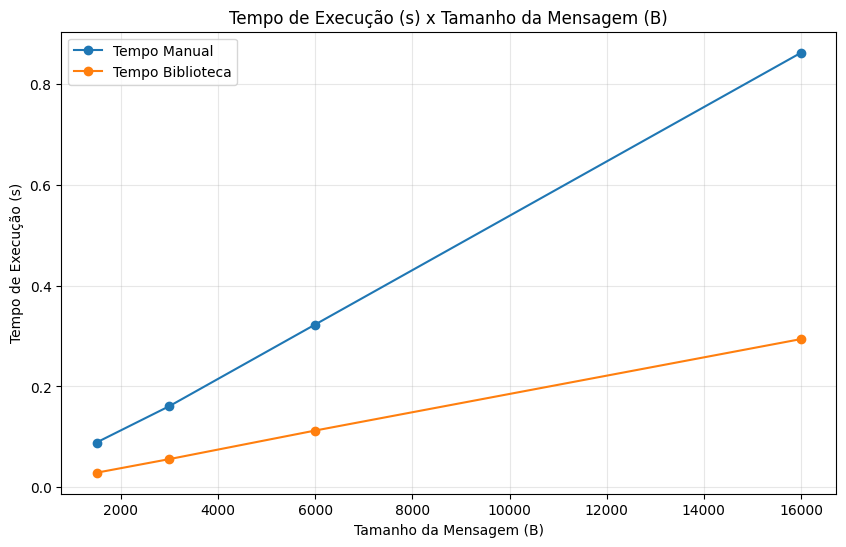

In [19]:
def prepareTempoManualData(resultados):
    tamanhos = []
    velocidades = []
    for resultado in resultados:
        tamanhos.append(resultado['tamanho'])
        velocidades.append(resultado['tempo_manual'])
    return tamanhos, velocidades

def prepareTempoLibData(resultados):
    tamanhos = []
    velocidades = []
    for resultado in resultados:
        tamanhos.append(resultado['tamanho'])
        velocidades.append(resultado['tempo_lib'])
    return tamanhos, velocidades

showGraph([prepareTempoManualData, prepareTempoLibData], ["Tempo Manual", "Tempo Biblioteca"], 'Tempo de Execução (s) x Tamanho da Mensagem (B)', 'Tempo de Execução (s)', 'Tamanho da Mensagem (B)')

#### Gerando gráfico de Memória de Pico x Tamanho da Mensagem

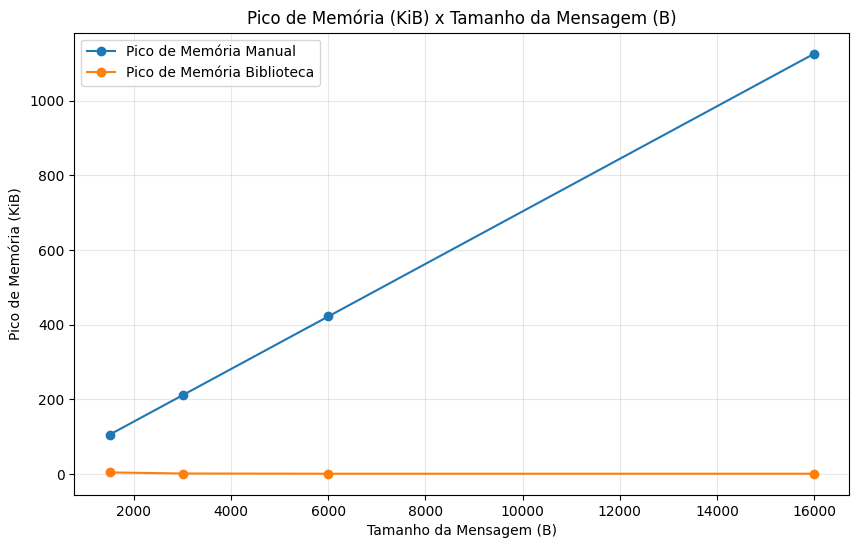

In [20]:
def prepareMemoriaPicoManualData(resultados):
    tamanhos = []
    velocidades = []
    for resultado in resultados:
        tamanhos.append(resultado['tamanho'])
        velocidades.append(resultado['mem_pico_manual'])
    return tamanhos, velocidades

def prepareMemoriaPicoLibData(resultados):
    tamanhos = []
    velocidades = []
    for resultado in resultados:
        tamanhos.append(resultado['tamanho'])
        velocidades.append(resultado['mem_pico_lib'])
    return tamanhos, velocidades

showGraph([prepareMemoriaPicoManualData, prepareMemoriaPicoLibData], ["Pico de Memória Manual", "Pico de Memória Biblioteca"], 'Pico de Memória (KiB) x Tamanho da Mensagem (B)', 'Pico de Memória (KiB)', 'Tamanho da Mensagem (B)')

#### Descrição da máquina na qual o Notebook está sendo rodado

```txt
Processador:
    Chip: Apple M4 Pro
    Arquitetura: ARM64
    Núcleos: 12
Modelo:
    Modelo: MacBook Pro
Memória:
    RAM: 24 GB
Sistema:
    OS: macOS
```

## Analisando de forma Investigativa da Detecção de Erros

Nossa mensagem pessoal será o nome dos alunos, nesse caso:
- Francisco Pereira da Silva Filho
- Hebert Laurentino dos Santos
- Pedro Henrique Lima Simões
- Samuel Lucas Vieira Matos

### Definindo as Mensagens e o CRC para cada uma

In [21]:
nomes_alunos = ["Francisco Pereira da Silva Filho",
                "Hebert Laurentino dos Santos",
                "Pedro Henrique Lima Simões",
                "Samuel Lucas Vieira Matos"]

crc_by_aluno = {
    "Francisco Pereira da Silva Filho": "11000000000000101",
    "Hebert Laurentino dos Santos": "10011000000010001",
    "Pedro Henrique Lima Simões": "10001000000100001",
    "Samuel Lucas Vieira Matos": "11000000000000101",
}


### Convertendo a mensagem para bits

1. convertStrToBits(str): converte a string para binario
2. randomInvertMask(msg): insire um **erro de rajada de $n$ bits**.
3. errorDetected(crc): detecta erro na string
4. detectErrorOnBoth(crc_manual, crc_lib, PADRAO_DE_ERRO, POSITION): **Registra o padrão de erro e a posição onde ele foi inserido**

In [22]:
import random

# 1
def convertStrToBits(str):
    return "".join([bin(ord(char))[2:].zfill(8) for char in str])

# 2
def randomInvertMask(msg):
    position = random.randint(0, len(msg)-1)
    n = random.randint(1, (len(msg) - position))

    invertionMask = '0' * position
    invertionMask += '1' * n
    invertionMask += '0' * (len(msg) - position - n)

    return invertionMask, position

# 3
def errorDetected(crc):
    for char in crc:
        if char != '0':
            return True
    return False

# 4
def detectErrorOnBoth(crc_manual, crc_lib, PADRAO_DE_ERRO, POSITION):
    manualDetected = errorDetected(crc_manual)
    libDetected = errorDetected(crc_lib)

    print(f"Padrão de error: {PADRAO_DE_ERRO}")
    print(f"Posição: {POSITION}")

    if (manualDetected): 
        print("[CRC Manual] Error detectado!")
    else:
        print("[CRC Manual] Error não detectado!")

    if (libDetected): 
        print("[CRC Lib] Error detectado!")
    else:
        print("[CRC Lib] Error não detectado!")

    return manualDetected and libDetected

### Realizando procedimento de teste

1. Calcule o CRC da sua `MENSAGEM_BASE`.
2. Forme o `QUADRO_TRANSMITIDO` (T(x)): concatene a mensagem com o CRC calculado.
3. Escolha uma **posição aleatória** e insira um **erro de rajada de $n$ bits** (e.g., uma sequência contínua de $n$ bits invertidos).
4. Obtenha o `QUADRO_CORROMPIDO`, aplicando XOR entre o `QUADRO_TRANSMITIDO` e o padrão de erro.
5. Calcule o CRC do `QUADRO_CORROMPIDO`, usando:
   * Sua função `calcular_crc_manual`.
   * A função da **biblioteca de CRC**.
6. Verifique se o erro foi detectado:
   * Se o CRC resultante for uma sequência de zeros, o erro **não foi detectado**.
   * Se o CRC resultante for diferente de zero, o erro **foi detectado**.
7. **Registre o padrão de erro e a posição onde ele foi inserido**, especialmente se não for detectado por uma das implementações.

In [23]:
import random

def processarAluno(MENSAGEM):
    CRC = crc_by_aluno[MENSAGEM]
    MENSAGEM_BASE = convertStrToBits(MENSAGEM)

    # Passo 1
    crc = calcular_crc_manual(MENSAGEM_BASE, CRC)

    # Passo 2
    QUADRO_TRANSMITIDO = str(MENSAGEM_BASE) + str(crc) # T(x)

    # Passo 3
    PADRAO_DE_ERRO, POSITION = randomInvertMask(QUADRO_TRANSMITIDO)

    # Passo 4
    QUADRO_CORROMPIDO = xor_bits(QUADRO_TRANSMITIDO, PADRAO_DE_ERRO)

    # Passo 5
    crc_manual = calcular_crc_manual(QUADRO_CORROMPIDO, CRC)

    QUADRO_CORROMPIDO_BYTES = bytes(int(QUADRO_CORROMPIDO[i:i+8], 2) for i in range(0, len(QUADRO_CORROMPIDO), 8))
    crc_lib = format(calculator_lib.checksum(QUADRO_CORROMPIDO_BYTES), '016b')

    # Passo 6 e 7
    if (not detectErrorOnBoth(crc_manual, crc_lib, PADRAO_DE_ERRO, POSITION)):
        print(f"Error não detectado em pelo menos um dos dois\n \
                POSITION={POSITION}\n \
                PADRAO_DE_ERRO={PADRAO_DE_ERRO}\n")
    
    
    # Rodando 10 vezes
    for _ in range(10):
        PADRAO_DE_ERRO, POSITION = randomInvertMask(QUADRO_TRANSMITIDO)
        QUADRO_CORROMPIDO = xor_bits(QUADRO_TRANSMITIDO, PADRAO_DE_ERRO)

        crc_manual = calcular_crc_manual(QUADRO_CORROMPIDO, CRC)

        QUADRO_CORROMPIDO_BYTES = bytes(int(QUADRO_CORROMPIDO[i:i+8], 2) for i in range(0, len(QUADRO_CORROMPIDO), 8))
        crc_lib = format(calculator_lib.checksum(QUADRO_CORROMPIDO_BYTES), '016b')

        if (not detectErrorOnBoth(crc_manual, crc_lib, PADRAO_DE_ERRO, POSITION)):
            print(f"Error não detectado em pelo menos um dos dois\n \
                    POSITION={POSITION}\n \
                    PADRAO_DE_ERRO={PADRAO_DE_ERRO}\n")
            

# Executar para cada aluno
for MENSAGEM in nomes_alunos:
    processarAluno(MENSAGEM)

Padrão de error: 00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011111111111110000000000000000000000000000000000000000
Posição: 219
[CRC Manual] Error detectado!
[CRC Lib] Error detectado!
Padrão de error: 00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000110000
Posição: 266
[CRC Manual] Error detectado!
[CRC Lib] Error detectado!
Padrão de error: 00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111111111111111111111111111111111111111111000000000000000000000000000000

Como podemos ver o error foi detectado em todas as execuções, então está tudo de acordo, pois realmente simulamos o error no quadro.

## Problema

Encontramos um leve problema, porém, se não simularmos error no quadro, a lib CRC ainda continua detectando error, podendo ser um error de nossa implementação ou da biblioteca:

In [24]:
import random

def processarAluno(MENSAGEM):
    print(MENSAGEM)
    CRC = crc_by_aluno[MENSAGEM]
    MENSAGEM_BASE = convertStrToBits(MENSAGEM)

    crc = calcular_crc_manual(MENSAGEM_BASE, CRC)

    QUADRO_TRANSMITIDO = str(MENSAGEM_BASE) + str(crc) # T(x)
    PADRAO_DE_ERRO, POSITION = randomInvertMask(QUADRO_TRANSMITIDO)

    QUADRO_CORROMPIDO = QUADRO_TRANSMITIDO

    crc_manual = calcular_crc_manual(QUADRO_CORROMPIDO, CRC)

    QUADRO_CORROMPIDO_BYTES = bytes(int(QUADRO_CORROMPIDO[i:i+8], 2) for i in range(0, len(QUADRO_CORROMPIDO), 8))
    crc_lib = format(calculator_lib.checksum(QUADRO_CORROMPIDO_BYTES), '016b')


    
    # Passo 7
    detectErrorOnBoth(crc_manual, crc_lib, PADRAO_DE_ERRO, POSITION)

for MENSAGEM in nomes_alunos:
    processarAluno(MENSAGEM)

Francisco Pereira da Silva Filho
Padrão de error: 00011111111111111111111111111111111111111111111111111111111111111111111111111111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Posição: 3
[CRC Manual] Error não detectado!
[CRC Lib] Error detectado!
Hebert Laurentino dos Santos
Padrão de error: 000000000000000000000000000000000000000000000000000000000000000000000000000000000000111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Posição: 84
[CRC Manual] Error não detectado!
[CRC Lib] Error detectado!
Pedro Henrique Lima Simões
Padrão de error: 000000000000000000000000000000000000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000000000000000000000000000000